In [1]:
### Importing Libraries...
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F

In [12]:
### DATA IMPORT AND DATA PROCESSING

#punctutation remover/data cleaner
def DataProcess(df):
  proc_close = []
  for i in (df):
    cls = i.replace(",", "")
    proc_close.append(cls)
  df = np.asarray(proc_close, dtype = float).reshape(df.shape[0], -1)
  return (df)

#get train and test Data 
dataTrain = pd.read_csv("/content/Google_Stock_Price_Train.csv")
dataTest = pd.read_csv("/content/Google_Stock_Price_Test.csv")

#call data cleaner
dataTrain = DataProcess(dataTrain['Close'])
dataTest = np.array(dataTest['Close']).reshape(dataTest.shape[0], -1)

dataTrain[:560] = dataTrain[:560]/2.002                                      #updating the dataset with  2 for 1 share, stock split.


#join train and test data
data = np.concatenate((dataTrain, dataTest))

#scaling the data
scaler = MinMaxScaler()
Close_scaled = scaler.fit_transform(np.array(data, dtype = 'float').reshape(-1,1))

In [14]:
## Define network...

class LSTM_net(nn.Module):
  
  def __init__(self, input_dim, hidden_dim, num_layers, bias, batch_first, dropout, bidirectional, output_dim):

    super().__init__()

    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.num_layers = num_layers
    self.bias = bias
    self.batch_first = batch_first
    self.dropout = dropout
    self.bidirectional = bidirectional
    self.output_dim = output_dim

    self.gru = nn.GRU(input_size=self.input_dim, hidden_size=self.hidden_dim, num_layers = self.num_layers, bias=self.bias,
                        batch_first = self.batch_first, dropout = self.dropout, bidirectional = self.bidirectional)

    self.linear = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):

    # Initial hidden (h0) state with zeros

    h0 = torch.zeros(self.num_layers, x.size(1), self.hidden_dim).requires_grad_()

    out, hn = self.gru(x, h0.detach())

    out = self.linear(out)

    return (out)

In [15]:
### Train model...

def Model(input_sz, hidden_sz, num_lays, bias, batch_first, dropout, bidirectional, out_dim, lr, simulation):

  # store all the values...
  losses = []   
  predTrain = []
  ytest = []
  ytest_pred = []
  chunk = 5

  # call model...
  model = LSTM_net(input_dim = input_sz, hidden_dim = hidden_sz, num_layers = num_lays, 
                 bias = bias, batch_first = batch_first, dropout = dropout, bidirectional  = bidirectional,
                 output_dim = out_dim)

  # loss function and optimizer function...
  criterion = torch.nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = lr)

  # Data iteration with step size
  for ix in range(chunk, Close_scaled.shape[0]):

    # Simulating to get minimum loss parameters
    for sim in range(simulation):
      dataX = torch.Tensor(np.array(Close_scaled[ix-chunk: ix], dtype = 'float')).reshape(1,chunk,1)
      dataY = Close_scaled[ix]
      ypred = model(dataX)
      predTrain.append(ypred.detach())

      # calculate loss of this iteration wrt to the step sized data
      loss = criterion(ypred, dataX)
  
      # update paramters
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    # Get the testing value  
    ytest.append(dataY)

    #save the loss
    losses.append(loss)

    # Predicting with test data
    with torch.no_grad():
      ytst = model(torch.Tensor(np.array(dataY, dtype = 'float')).reshape(1,1,1))
      ytest_pred.append(ytst)

  return (losses, ytest, ytest_pred)

In [16]:
def plot_model(losses, ytest, ytest_pred):
  ### Visulaization

  # plot for losses

  plt.plot(losses)
  plt.ylim(0, 0.2)
  plt.title("Mean Square Loss") 
  plt.xlabel("Total Data")
  plt.ylabel("MSE")
  plt.show()


  # plot for actual train data and predicted train data
  plt.figure(figsize = (30,10))
  plt.plot(range(0, 1253), ytest[:1253], label = "Actual Train Data")
  plt.plot(range(0, 1253), ytest_pred[:1253], label = "Predicted Train Data")
  plt.title("Actual Train Data Vs Predicted Train Data")
  plt.xlabel("Toatl Data")
  plt.ylabel("Actaul/Predicted Data")
  plt.legend()
  plt.show()


  # zooming test data and test prediction
  plt.figure(figsize = (20,8))
  plt.plot(range(1253, 1273), ytest[1253:], label = "Actual Test Data")
  plt.plot(range(1253, 1273), ytest_pred[1253:], label = "Predicted Test Data") 
  plt.title("Actual Test Data Vs Predicted Test Data")
  plt.xlabel("Toatl Data")
  plt.ylabel("Actaul/Predicted Data")
  plt.legend()
  plt.show()


  # plot for combined Acrual and Predicted Train - Test data

  plt.figure(figsize = (30,10))
  plt.plot(range(0, 1253), ytest[:1253], label = "Actual Train Data")
  plt.plot(range(0,1253), ytest_pred[:1253], label = "Predicted Train Data")
  plt.plot(range(1253, 1273), ytest[1253:], label = "Actual Test Data")
  plt.plot(range(1253, 1273), ytest_pred[1253:], label = "Predicted Test Data")
  plt.title("Actual Data Vs Predicted Data")
  plt.xlabel("Toatl Data")
  plt.ylabel("Actaul/Predicted Data")
  plt.legend()
  plt.show()

  return

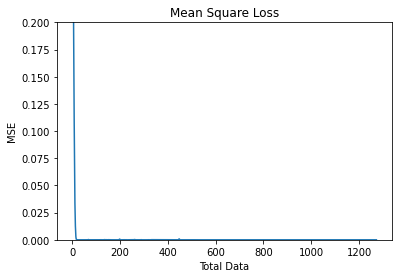

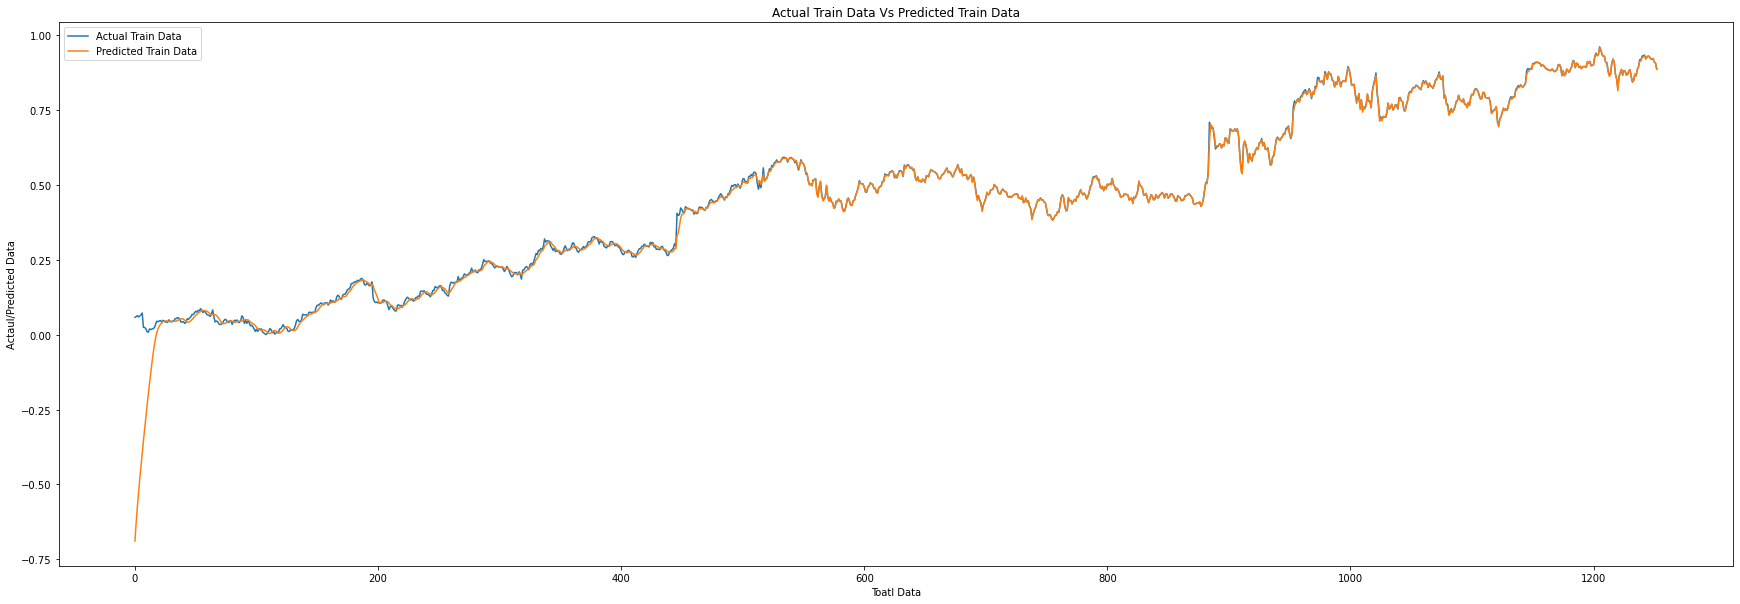

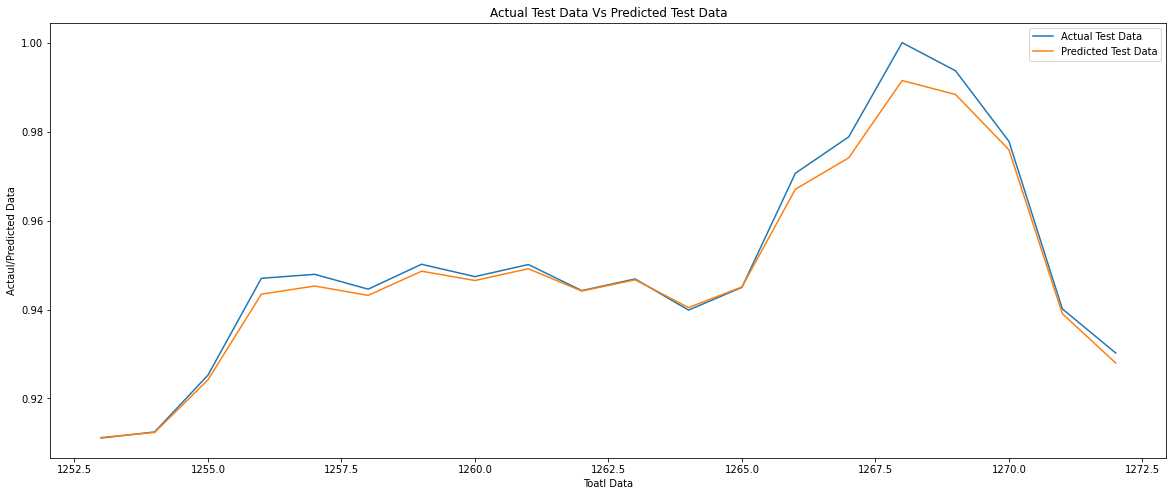

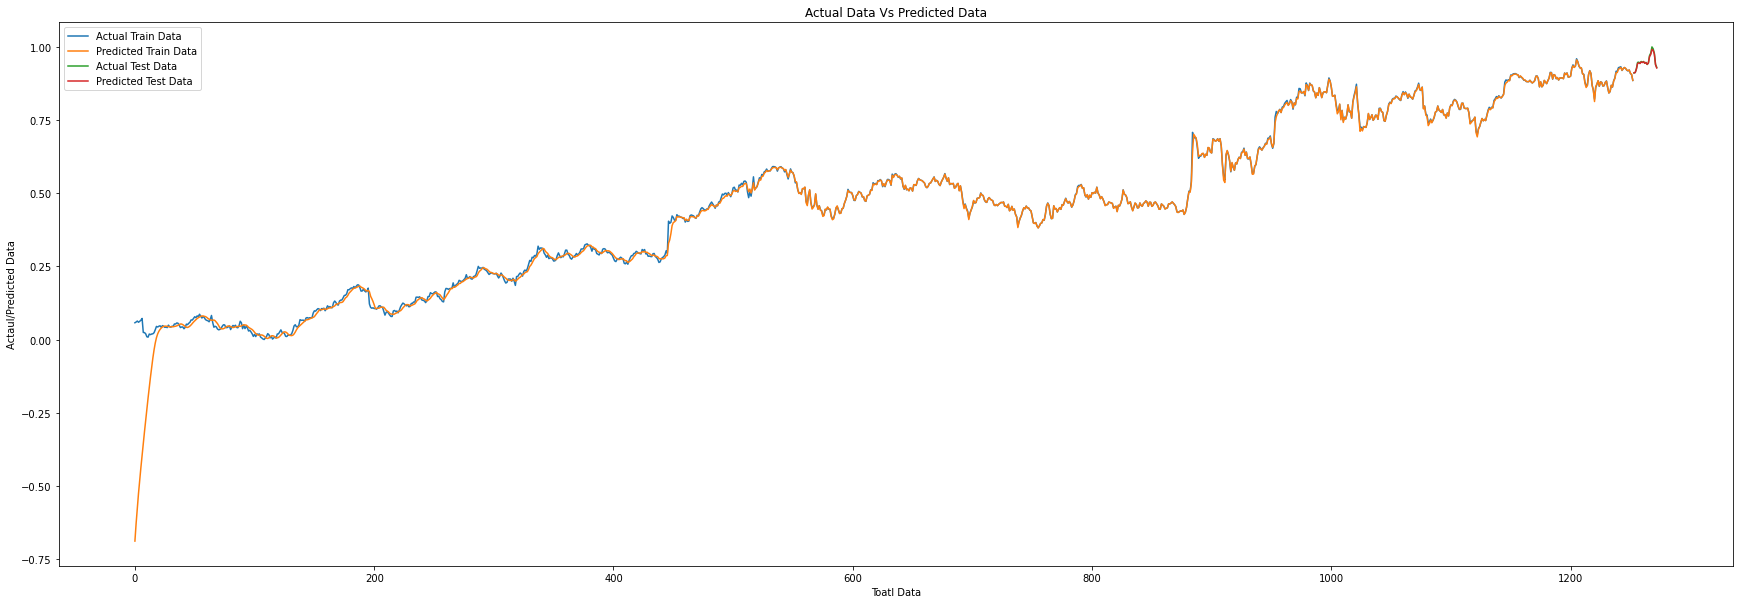

   Mean squared error  Mean absolute error  R2_Score
0             0.00247             0.008989  0.967681


In [17]:
## Experiment -1

input_sz = 1
hidden_sz = 1
num_lays = 2
bias = True
batch_first = False
dropout = 0
bidirect = False
out_dim = 1
lr = 0.005
simulation = 10

losses1, ytest1, ytest_pred1 =  Model(input_sz = input_sz, hidden_sz = hidden_sz, num_lays = num_lays, bias = bias,
                                      batch_first = batch_first, dropout = dropout, bidirectional = bidirect, out_dim = out_dim, lr = lr, simulation=simulation)

plot_model(losses1, ytest1, ytest_pred1)

result1 = {'Mean squared error': [mean_squared_error(ytest1, ytest_pred1)],
          'Mean absolute error': [mean_absolute_error(ytest1, ytest_pred1)],
          'R2_Score': [r2_score(ytest1, ytest_pred1)]}

print(pd.DataFrame.from_dict(result1))

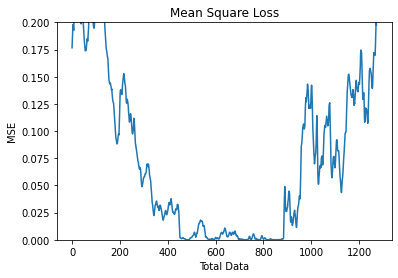

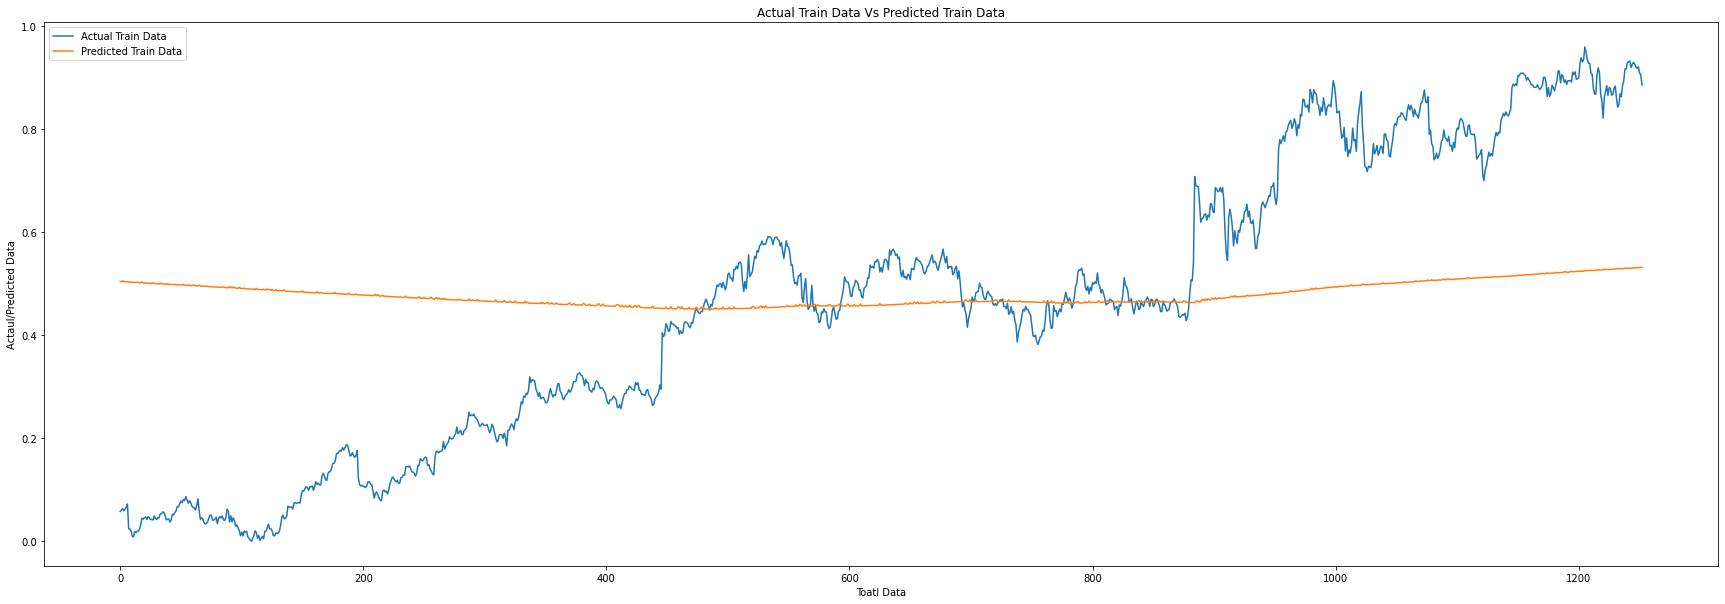

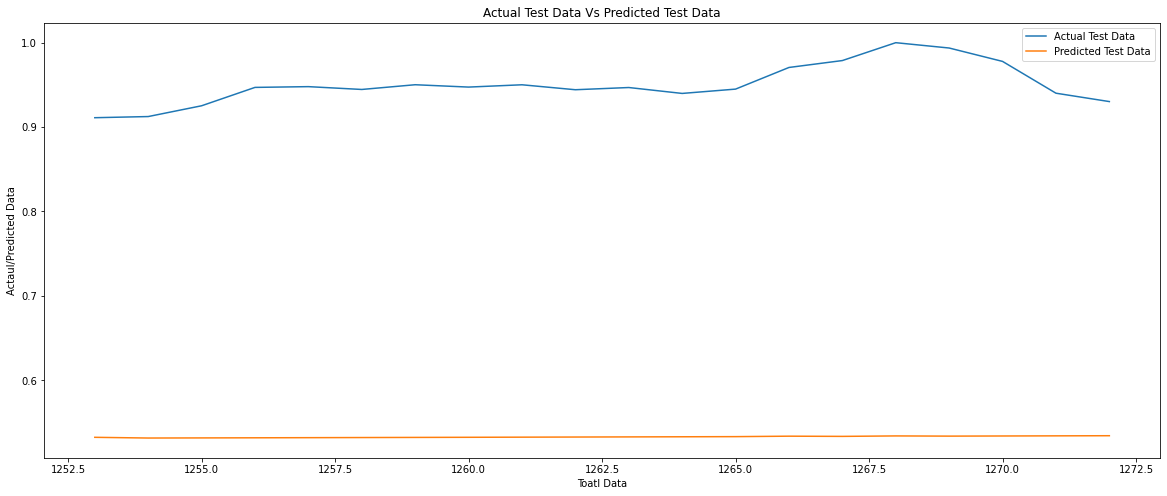

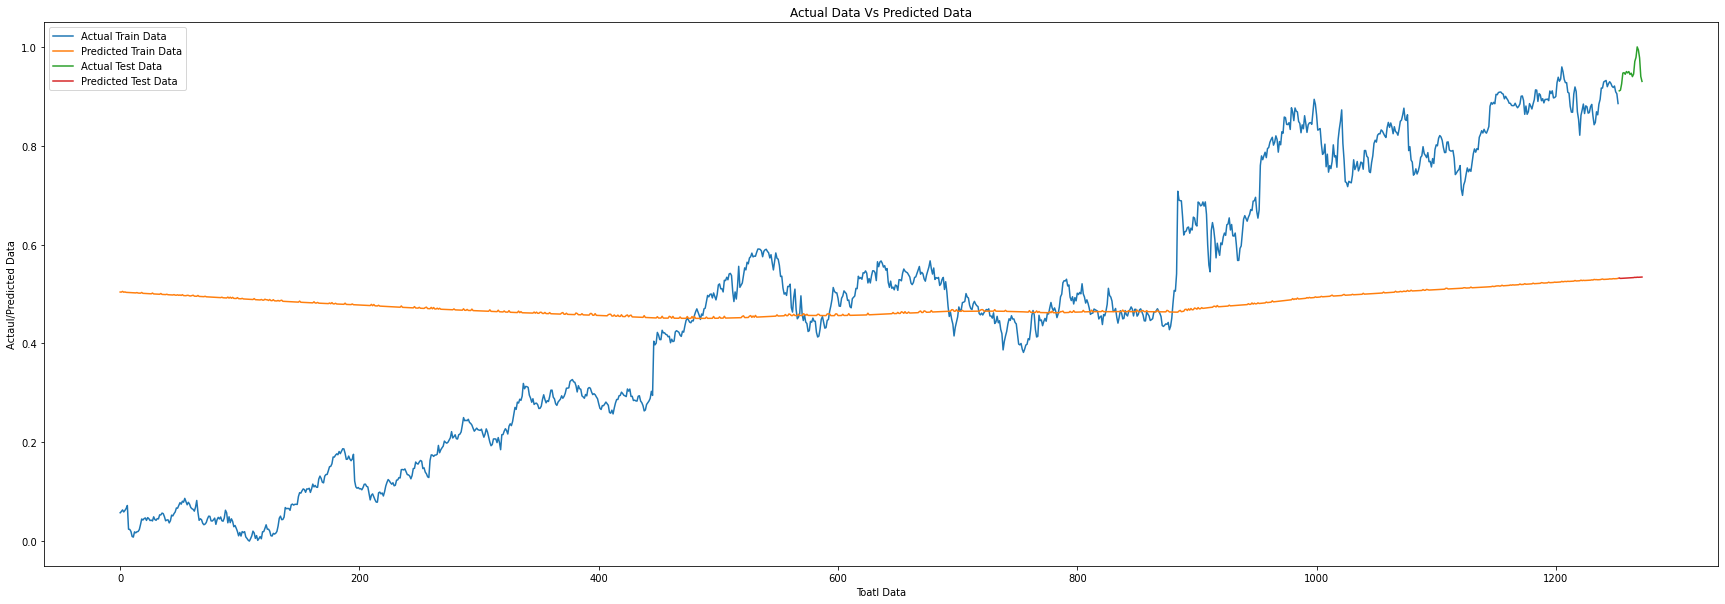

   Mean squared error  Mean absolute error  R2_Score
0            0.071661              0.21908  0.062333


In [18]:
## Experiment -2(As a learning rate decreases fit doesnt happen)

input_sz = 1
hidden_sz = 1
num_lays = 4
bias = True
batch_first = False
dropout = 0.1
bidirect = False
out_dim = 1
lr = 0.00001
simulation = 10

losses2, ytest2, ytest_pred2 =  Model(input_sz = input_sz, hidden_sz = hidden_sz, num_lays = num_lays, bias = bias,
                                      batch_first = batch_first, dropout = dropout, bidirectional = bidirect, out_dim = out_dim, lr = lr, simulation=simulation)

plot_model(losses2, ytest2, ytest_pred2)

result2 = {'Mean squared error': [mean_squared_error(ytest2, ytest_pred2)],
          'Mean absolute error': [mean_absolute_error(ytest2, ytest_pred2)],
          'R2_Score': [r2_score(ytest2, ytest_pred2)]}

print(pd.DataFrame.from_dict(result2))

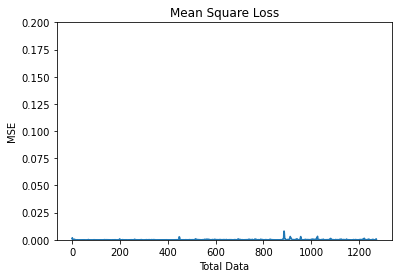

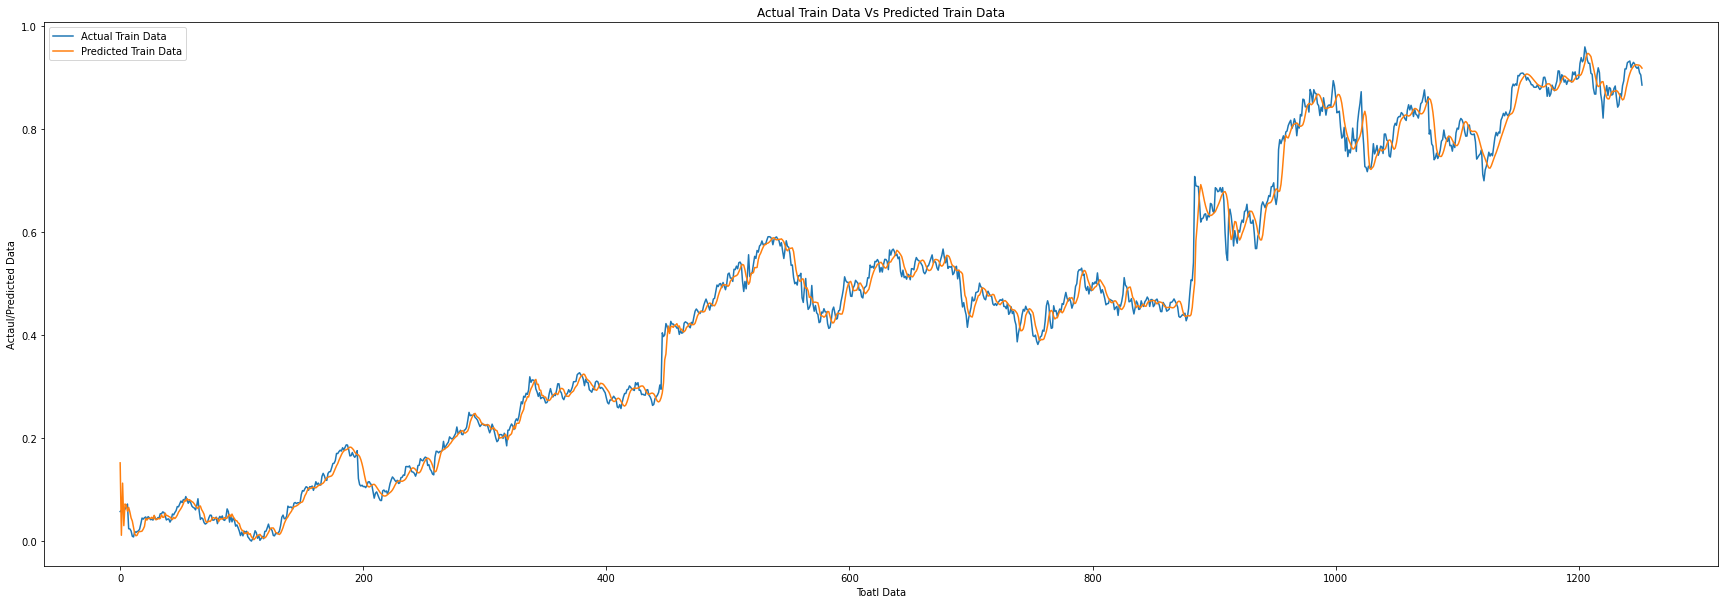

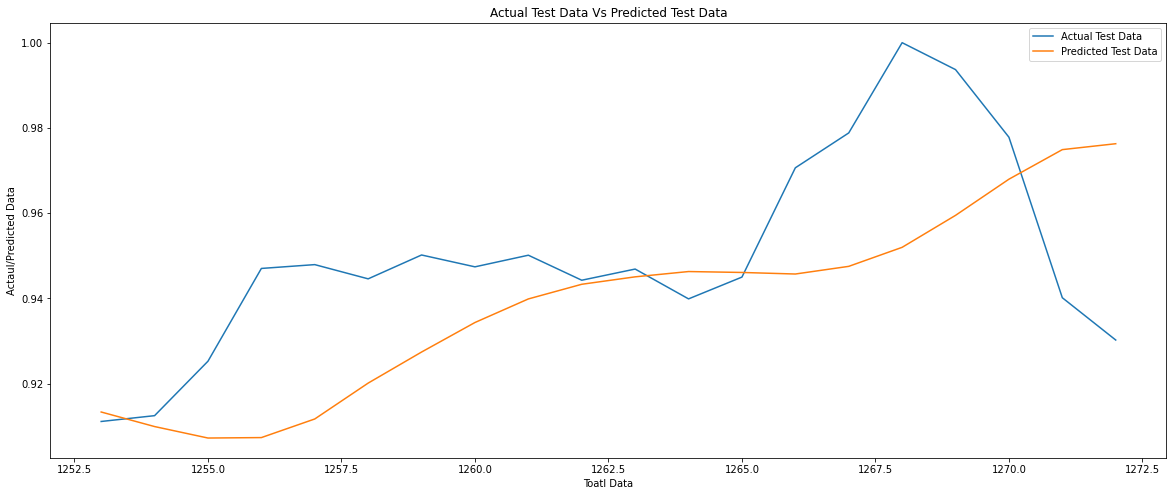

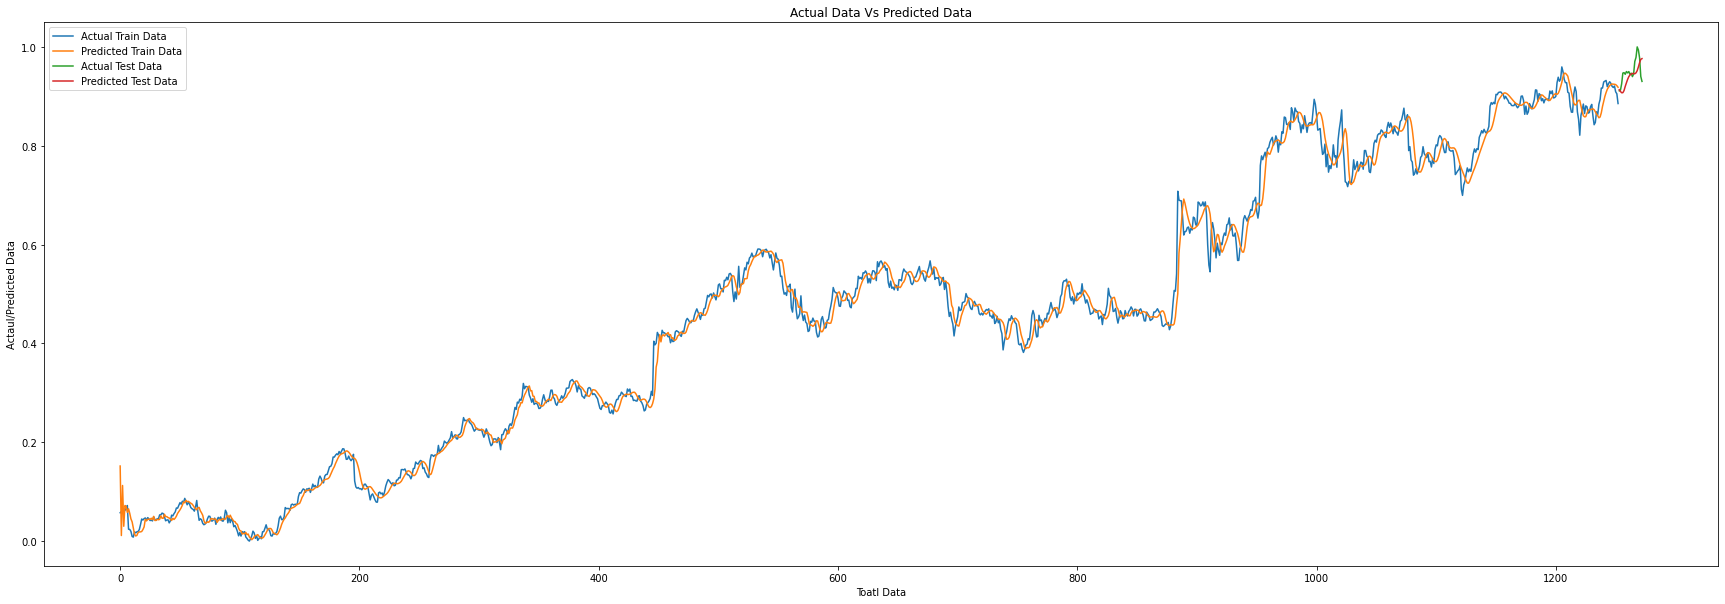

   Mean squared error  Mean absolute error  R2_Score
0            0.000538             0.016202  0.062333


In [19]:
## Experiment -3

input_sz = 1
hidden_sz = 1
num_lays = 4
bias = True
batch_first = False
dropout = 0.1
bidirect = False
out_dim = 1
lr = 0.1
simulation = 10

losses3, ytest3, ytest_pred3 =  Model(input_sz = input_sz, hidden_sz = hidden_sz, num_lays = num_lays, bias = bias,
                                      batch_first = batch_first, dropout = dropout, bidirectional = bidirect, out_dim = out_dim, lr = lr, simulation=simulation)

plot_model(losses3, ytest3, ytest_pred3)

result3 = {'Mean squared error': [mean_squared_error(ytest3, ytest_pred3)],
          'Mean absolute error': [mean_absolute_error(ytest3, ytest_pred3)],
          'R2_Score': [r2_score(ytest2, ytest_pred2)]}

print(pd.DataFrame.from_dict(result3))

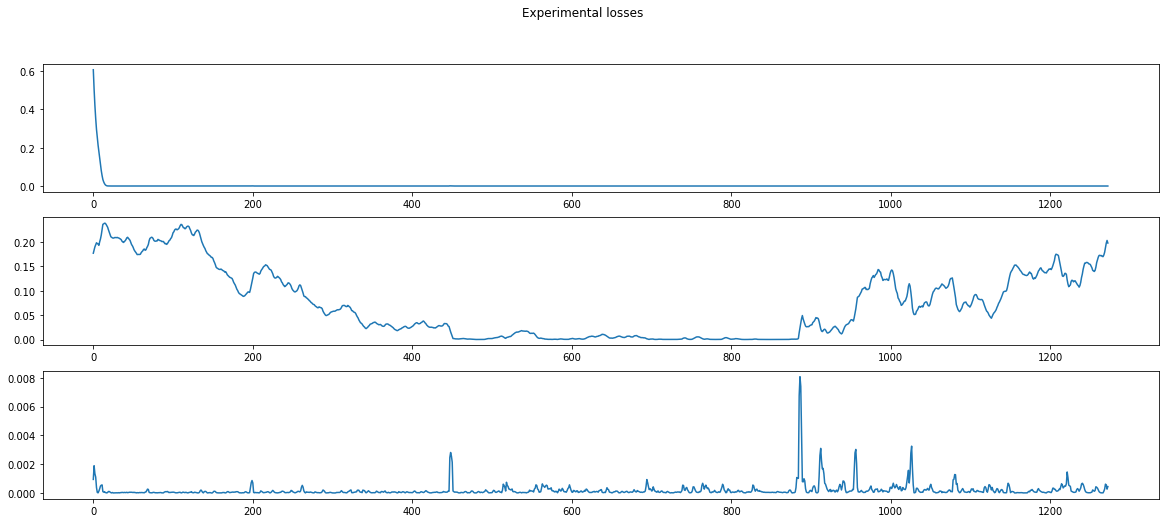

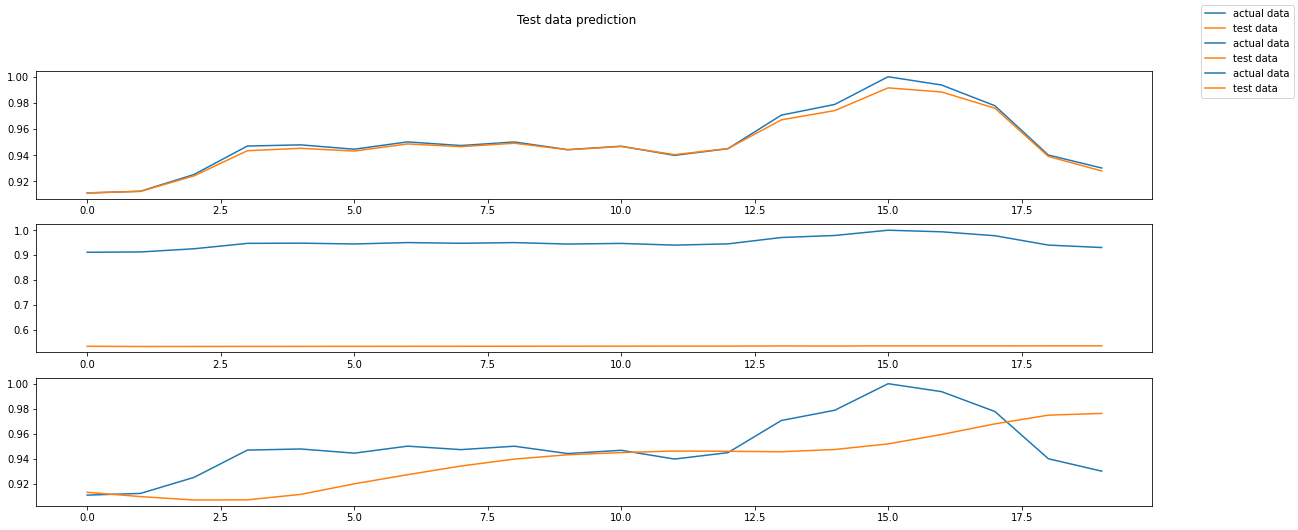

In [20]:
# overall test reults

fig, ax = plt.subplots(nrows = 3, ncols= 1)
fig.suptitle("Experimental losses")
fig.set_figheight(8)
fig.set_figwidth(20)
ax[0].plot(losses1)
ax[1].plot(losses2)
ax[2].plot(losses3)
fig.show()


fig1, ax1 = plt.subplots(nrows = 3, ncols= 1)
fig1.suptitle("Test data prediction")
fig1.set_figheight(8)
fig1.set_figwidth(20)
ax1[0].plot(ytest1[1253:], label = "actual data")
ax1[0].plot(ytest_pred1[1253:], label = "test data")
ax1[1].plot(ytest2[1253:], label = "actual data")
ax1[1].plot(ytest_pred2[1253:], label = "test data")
ax1[2].plot(ytest3[1253:], label = "actual data")
ax1[2].plot(ytest_pred3[1253:], label = "test data")
fig1.legend()
fig1.show()

In [21]:
performance = {'Test 1': result1,
               'Test 2': result2,
               'Test 3': result3,
              }

pd.DataFrame(performance)

,Test 1,Test 2,Test 3
Mean squared error,[0.002469970020643092],[0.07166129456508087],[0.0005381227655158079]
Mean absolute error,[0.00898948945932547],[0.2190796938579791],[0.01620154717649748]
R2_Score,[0.9676811579901766],[0.06233272553435498],[0.06233272553435498]
